In [11]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import plotly.express as px 
import matplotlib.pyplot as plt 

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.decomposition import PCA 
from sklearn.metrics import r2_score,mean_squared_error,silhouette_score, confusion_matrix, accuracy_score 
from sklearn.pipeline import Pipeline 
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsClassifier

In [13]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [14]:


mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [15]:
# data.drop(columns=['Unnamed: 0'], inplace=True)

data.duplicated().sum()
data.drop_duplicates(inplace=True,subset=None, keep='last', ignore_index=False)
data.duplicated().sum()

0

<AxesSubplot:title={'center':'Correlation Matrix'}>

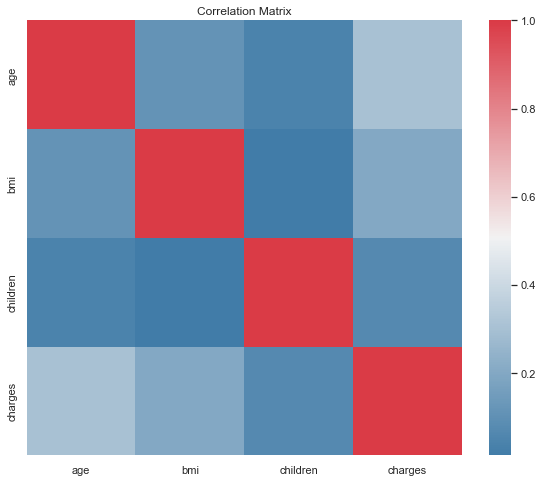

In [16]:
data_corr = data.corr()

f,ax = plt.subplots(figsize=(10,8))

ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(240,10, as_cmap=True), ax=ax, square=True)

In [17]:
orig_sex = data.sex 
orig_sex_dic = np.unique(orig_sex)

In [18]:
le = LabelEncoder()

data.sex = le.fit_transform(data.sex)

data.region = le.fit_transform(data.region)

data.smoker = le.fit_transform(data.smoker)

In [19]:
le_sex = data.sex 

le_sex_dic = np.unique(le_sex)

sex_dic = dict(zip(orig_sex_dic,le_sex_dic))

sex_dic

{'female': 0, 'male': 1}

In [20]:
x = data.drop(['charges'], axis=1)
y = data.charges

In [21]:
scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x))
y = scaler.fit_transform(np.array(y).reshape(-1,1))

In [22]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.3)

In [23]:
randfor = RandomForestRegressor(n_jobs=-1, criterion='squared_error', n_estimators=100, random_state=42)

randfor.fit(x_train,y_train)

y_pred = randfor.predict(x_test)

mse_ranfor = mean_squared_error(y_test,y_pred).round(3)

modperf = pd.DataFrame( 
     [ 
        'RandomForestRegressor', mse_ranfor
     ]
).transpose()

modperf.columns = ['Method', 'Mse Test']

modperf





C:\Users\amunv\AppData\Local\Temp\ipykernel_2132\3013465057.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randfor.fit(x_train,y_train)


,Method,Mse Test
0,RandomForestRegressor,0.181
